# Inverse $\widehat{I}_D$

We recall that the onion-peeling method allows us to compute:
$$
\forall (k, l) \in \llbracket - \frac{n}{2}, \frac{n}{2}\rrbracket^2, \, \widehat{I}_D(k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{2ku + 2lv}{m} \right)
$$

We define:
$$
\begin{align*}
\mathcal{F}_D : \, &\mathbb{C}^n \to \mathbb{C}^{n+1} \\
&x \mapsto \left( \mathcal{F}_D(x) : k \in \llbracket - \frac{n}{2}, \frac{n}{2} \rrbracket \mapsto \sum_{u \in \mathcal{D}(n)} x(u) \exp\left(-2i\pi \frac{2ku}{m}\right) \right)
\end{align*}
$$

$\widehat{I}_D(k, l)$ can be obtained in the following way:
- for all $u \in \mathcal{D}(n)$, compute $\mathcal{F}_D(I(u, :))$. We get an $n \times (n + 1)$ array $A$ such that:
$$A(u, l) = \mathcal{F}_D(I(u, :))(l) $$
- for all $l \in \llbracket - \frac{n}{2}, \frac{n}{2} \rrbracket$, compute $\mathcal{F}_D(A(:, l))$. The result is stored as:
$$R(k, l) = \mathcal{F}_D(A(:, l))(k) = \widehat{I}_D(k, l)$$

We would like to invert this transformation, getting $I$ back from $\widehat{I}_D$. For each column $l$ of $\widehat{I}_D$, we solve:
$$
\min_{x \in \mathbb{C}^n} \|\mathcal{F}_D(x) - \widehat{I}(:, l) \|^2
$$

which is supposed to be $A(:, l)$. Then, for each line $u$ of $A$, we solve again:
$$
\min_{x \in \mathbb{C}^n} \|\mathcal{F}_D(x) - A(u, :) \|^2
$$

which is supposed to be $I(u, :)$. We solve these minimization problems by computing:
$$
x = \left( \mathcal{F}_D^\dagger \circ \mathcal{F}_D \right)^{-1} \circ \mathcal{F}_D^\dagger (y)
$$

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from pad import pad, adj_pad
from new_fft import new_fft, adj_new_fft, new_fft2

## Implementation of $\mathcal{F}_D$ and its adjoint

In [2]:
def D(n):
    q_n, r_n = divmod(n, 2)
    return np.arange(-q_n, q_n + r_n)

In [3]:
def F_D(x):
    n = len(x)
    m = 2 * n + 1
    pad_x = pad(x, (m,))

    fft = new_fft(pad_x)

    if n%2 == 0:
        return fft[::2]
    
    else:
        return np.roll(fft, 1)[::2]

def check_F_D(x):
    n = len(x)
    m = 2 * n + 1
    k = D(n + 1)
    u = D(n)
    ku = np.einsum("k,u->ku", k, u)
    res = np.einsum("u,ku->k", x, np.exp(-2j * np.pi * 2 * ku / m))
    return res

def adj_F_D(y):
    n = len(y) - 1
    m = 2 * n + 1
    aux = np.zeros(shape=(m,), dtype=complex)
    aux[::2] = y

    if n%2 == 0:
        return adj_pad(adj_new_fft(aux), original_shape=(n,))
    
    else:
        return adj_pad(adj_new_fft(np.roll(aux, -1)), original_shape=(n,))

In [4]:
n = 10
x = np.random.rand(n)
print(np.max(np.abs(F_D(x) - check_F_D(x))))

n = 11
x = np.random.rand(n)
print(np.max(np.abs(F_D(x) - check_F_D(x))))

1.4217791915866692e-15
2.4732071290884353e-15


In [5]:
n = 10
x = np.random.rand(n) + 1j * np.random.rand(n)
y = np.random.rand(n + 1) + 1j * np.random.rand(n + 1)
print(np.vdot(F_D(x), y) - np.vdot(x, adj_F_D(y)))

n = 11
x = np.random.rand(n) + 1j * np.random.rand(n)
y = np.random.rand(n + 1) + 1j * np.random.rand(n + 1)
print(np.vdot(F_D(x), y) - np.vdot(x, adj_F_D(y)))

(8.881784197001252e-16+6.661338147750939e-16j)
(3.552713678800501e-15+0j)


# Computation of $\mathcal{F}_D^\dagger \mathcal{F}_D$ and inverse

Represented as a matrix, $\mathcal{F}_D^\dagger \mathcal{F}_D$ is:
$$
\mathcal{F}_D^\dagger \mathcal{F}_D(k, l) = \sum_{u \in \mathcal{D}(n)} \exp\left(4i\pi \frac{u (k - l)}{m} \right)
$$

which is a Toeplitz hermitian matrix. Therefore we can invert it using the same method we used for the fast resampling of trigonometric polynomials.

In [6]:
from fast_resampling import compute_inverse

In [7]:
def compute_FDdaggerFD(n):
    m = 2 * n + 1
    u = D(n + 1)
    k_minus_l = D(n)[:, None] - D(n)[None, :]
    u_times_k_minus_l = np.einsum("u,kl->ukl", u, k_minus_l)
    return np.einsum("ukl->kl", np.exp(4j * np.pi * u_times_k_minus_l / m))


In [8]:
def solve_min(y):
    n = len(y) - 1
    T = compute_FDdaggerFD(n)
    inv_T = compute_inverse(T[:, 0])
    return inv_T @ adj_F_D(y)


In [9]:
n = 10
x = np.random.rand(n)
y = F_D(x)
sol = solve_min(y)
print(np.max(np.abs(x - sol)))

n = 11
x = np.random.rand(n)
y = F_D(x)
sol = solve_min(y)
print(np.max(np.abs(x - sol)))

3.33237998494217e-16
4.041272810440265e-16


# Whole algorithm

In [10]:
def inverse_Id(Id):
    n = Id.shape[0] - 1

    A = np.zeros(shape=(n, n + 1), dtype=complex)
    res = np.zeros(shape=(n, n), dtype=complex)
    
    for l, col in enumerate(Id.T):
        A[:, l] = solve_min(col)

    for u, row in enumerate(A):
        res[u, :] = solve_min(row)

    return res


# Test

In [11]:
def compute_true_Id(im):
    n = len(im)
    m = 2 * n + 1
    pad_im = pad(im, (m, m))
    return new_fft2(pad_im)[::2, ::2]

In [12]:
def alternative_Id(im):
    n = len(im)
    A = np.zeros(shape=(n, n + 1), dtype=complex)
    R = np.zeros(shape=(n + 1, n + 1), dtype=complex)

    for u, row in enumerate(im):
        A[u] = F_D(row)

    for l, col in enumerate(A.T):
        R[:, l] = F_D(col)

    return R

In [13]:
n = 10
im = np.random.rand(n, n)

compute_true_Id(im) - alternative_Id(im)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,

In [16]:
n = 10
im = np.random.rand(n, n)
Id = compute_true_Id(im)
sol = inverse_Id(Id)
print(np.max(np.abs(sol - im)))

1.4266479795560002e-14


In [19]:
im = plt.imread("Shepp_logan_240.png")
im = im[::, ::]
Id = compute_true_Id(im)
sol = inverse_Id(Id)
print(np.max(np.abs(sol - im)))

1.434746535409874e-14


[None, None, None]

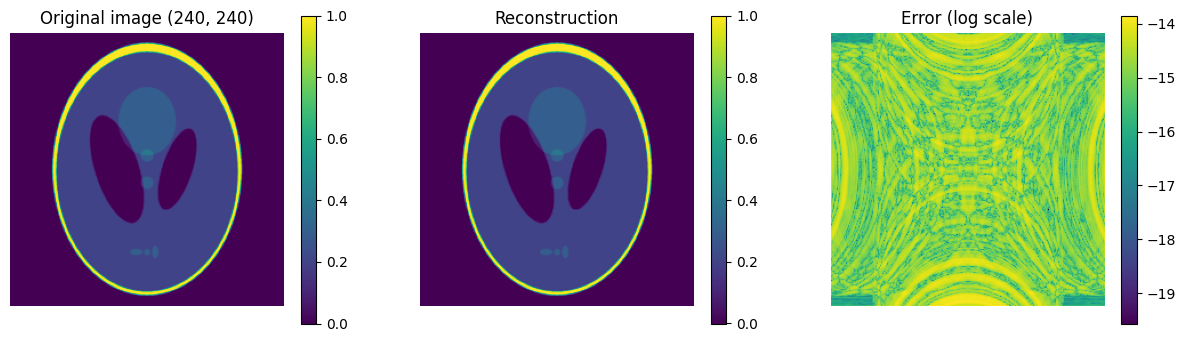

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

a = axes[0].imshow(im)
plt.colorbar(a, ax=axes[0])
axes[0].set_title(f"Original image {im.shape}")

a = axes[1].imshow(sol.real)
plt.colorbar(a, ax=axes[1])
axes[1].set_title("Reconstruction")

a = axes[2].imshow(np.log10(np.abs(im - sol)))
plt.colorbar(a, ax=axes[2])
axes[2].set_title("Error (log scale)")

[ax.set_axis_off() for ax in axes]

In [33]:
np.log(np.abs(im - sol))

array([[-36.74729631, -37.36959729, -36.85576965, ..., -36.3069043 ,
        -36.58734396, -36.53575911],
       [-37.12964688, -37.34644296, -37.37636036, ..., -37.18158711,
        -37.58863225, -37.43159345],
       [-36.81142219, -37.16434792, -36.7248363 , ..., -36.74375729,
        -37.18814017, -36.71527928],
       ...,
       [-37.00147547, -37.3499981 , -37.26416459, ..., -36.83654687,
        -36.92865138, -36.8304538 ],
       [-37.05652005, -37.43983136, -36.92914752, ..., -36.95257428,
        -37.33293411, -36.94718959],
       [-35.98044623, -36.29856757, -36.15409283, ..., -36.04745237,
        -36.33627588, -35.9900265 ]])

# Full inversion

In [145]:
from ppfft import ppfft
from onion_peeling import onion_peeling

In [202]:
n = 100
im = np.random.rand(n, n)
hori, vert = ppfft(im)
Id = onion_peeling(hori, vert)
sol = inverse_Id(Id)
print(np.max(np.abs(im - sol)))

4.962416466636199e-08


# With a real image

In [203]:
import matplotlib.pyplot as plt

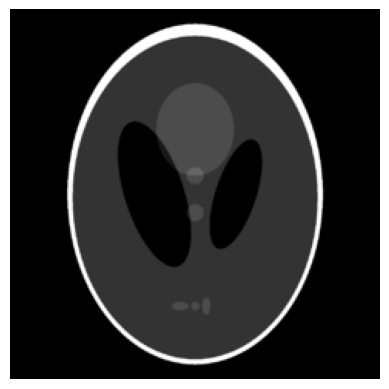

In [204]:
im = plt.imread("Shepp_logan_240.png")

plt.imshow(im, cmap='gray')
plt.axis("off")
plt.show()

In [205]:
hori, vert = ppfft(im)
Id = onion_peeling(hori, vert)
sol = inverse_Id(Id)

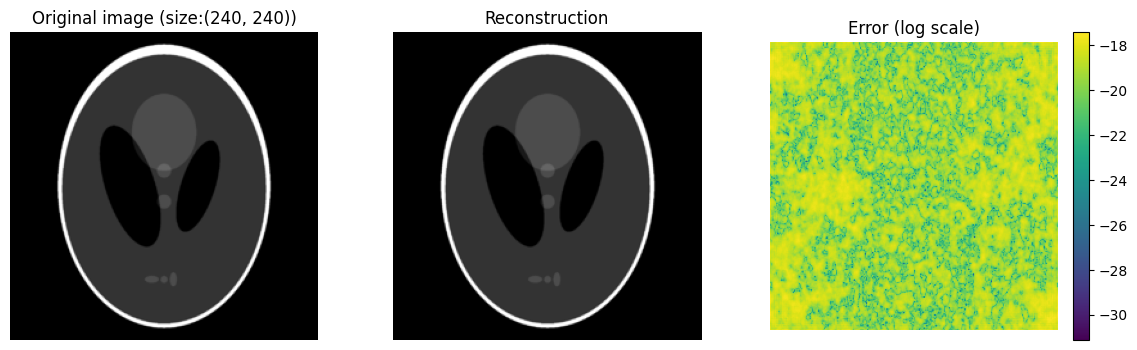

In [206]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].imshow(im, cmap='gray')
axes[0].set_axis_off()
axes[0].set_title(f"Original image (size:{im.shape})")

axes[1].imshow(np.real_if_close(sol), cmap='gray')
axes[1].set_axis_off()
axes[1].set_title("Reconstruction")

err = axes[2].imshow(np.log(np.abs(im - sol)))
plt.colorbar(err, ax=axes[2], fraction=0.05)
axes[2].set_axis_off()
axes[2].set_title("Error (log scale)")

plt.show()